<a href="https://colab.research.google.com/github/MehakArora/ImageInpainting/blob/main/New_Vanilla_Encodeer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install --upgrade opencv-contrib-python
!pip install tensorflow-gpu==2.0

     |████████████████████████████████| 66.7 MB 32 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 380.8 MB 42 kB/s 
     |████████████████████████████████| 449 kB 47.9 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 3.8 MB 31.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=030d82ddbf6866a806f1fb2d1635a3a72b2007d585080a1a7f3950eb55b51e51
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attemp

In [3]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.python.client import device_lib

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.0.0
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
import os
import cv2
print(cv2.__version__)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from skimage.metrics import structural_similarity as SSIM

from mpl_toolkits.axes_grid1 import ImageGrid

4.5.5


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/content/drive/MyDrive/ECE_6254/archive(1).zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
seg_train/seg_train/mountain/7539.jpg          2019-10-18 05:52:02        16948
seg_train/seg_train/mountain/7551.jpg          2019-10-18 05:52:02         8318
seg_train/seg_train/mountain/7560.jpg          2019-10-18 05:52:02         8029
seg_train/seg_train/mountain/7565.jpg          2019-10-18 05:52:02        10892
seg_train/seg_train/mountain/7578.jpg          2019-10-18 05:52:02        11674
seg_train/seg_train/mountain/7581.jpg          2019-10-18 05:52:02        14910
seg_train/seg_train/mountain/7586.jpg          2019-10-18 05:52:02         6908
seg_train/seg_train/mountain/7647.jpg          2019-10-18 05:52:02        20167
seg_train/seg_train/mountain/7652.jpg          2019-10-18 05:52:02        11952
seg_train/seg_train/mountain/7654.jpg          2019-10-18 05:52:02        11998
seg_train/seg_train/mountain/7662.jpg          2019-10-18 05:52:02         7367
seg_train/seg_train/mountain/767.jpg           2019-10-18 05:52:02   

In [7]:
"Getting File Names"

#Train Data
train_path = './seg_train/seg_train/'
train_folders = os.listdir(train_path)
train_files = []

for folder in train_folders:
    files_f = os.listdir(train_path + folder + '/')
    for file in files_f:
        train_files.append(train_path + folder + '/' + file)
        
#Val Data
val_path = './seg_test/seg_test/'
val_folders = os.listdir(val_path)
val_files = []

for folder in val_folders:
    files_f = os.listdir(val_path + folder + '/')
    for file in files_f:
        val_files.append(val_path + folder + '/' + file)
  
#Testing Data
pred_path = './seg_pred/seg_pred/'
pred_files = []


for file in os.listdir(pred_path):
    pred_files.append(pred_path + file)

In [8]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(64, 64), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255
      
    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((64,64,3), 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 64), np.random.randint(1, 64)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 64), np.random.randint(1, 64)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

In [9]:
import cv2

x_train = []
for file_path in train_files:
  img = cv2.imread(file_path)
  resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  x_train.append(resized)
  
x_train = np.array(x_train)


x_val = []
for file_path in val_files:
  img = cv2.imread(file_path)
  resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  x_val.append(resized)
  
x_val = np.array(x_val)

x_pred = []
for file_path in pred_files:
  img = cv2.imread(file_path)
  resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  x_pred.append(resized)
  
x_pred = np.array(x_pred)


(64, 64, 3)


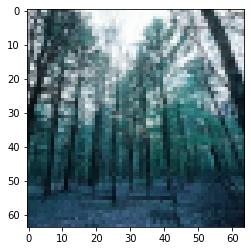

In [10]:
img = x_train[0]
#resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
#plt.imshow(img)
print(img.shape)
plt.imshow(img)


In [11]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_val, x_val, shuffle=False)

In [12]:
len(traingen)

438

In [13]:
def dice_coef(y_true, y_pred):
   y_true_f = keras.backend.flatten(y_true)
   y_pred_f = keras.backend.flatten(y_pred)
   intersection = keras.backend.sum(y_true_f * y_pred_f)
   return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [14]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(64,64,3)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

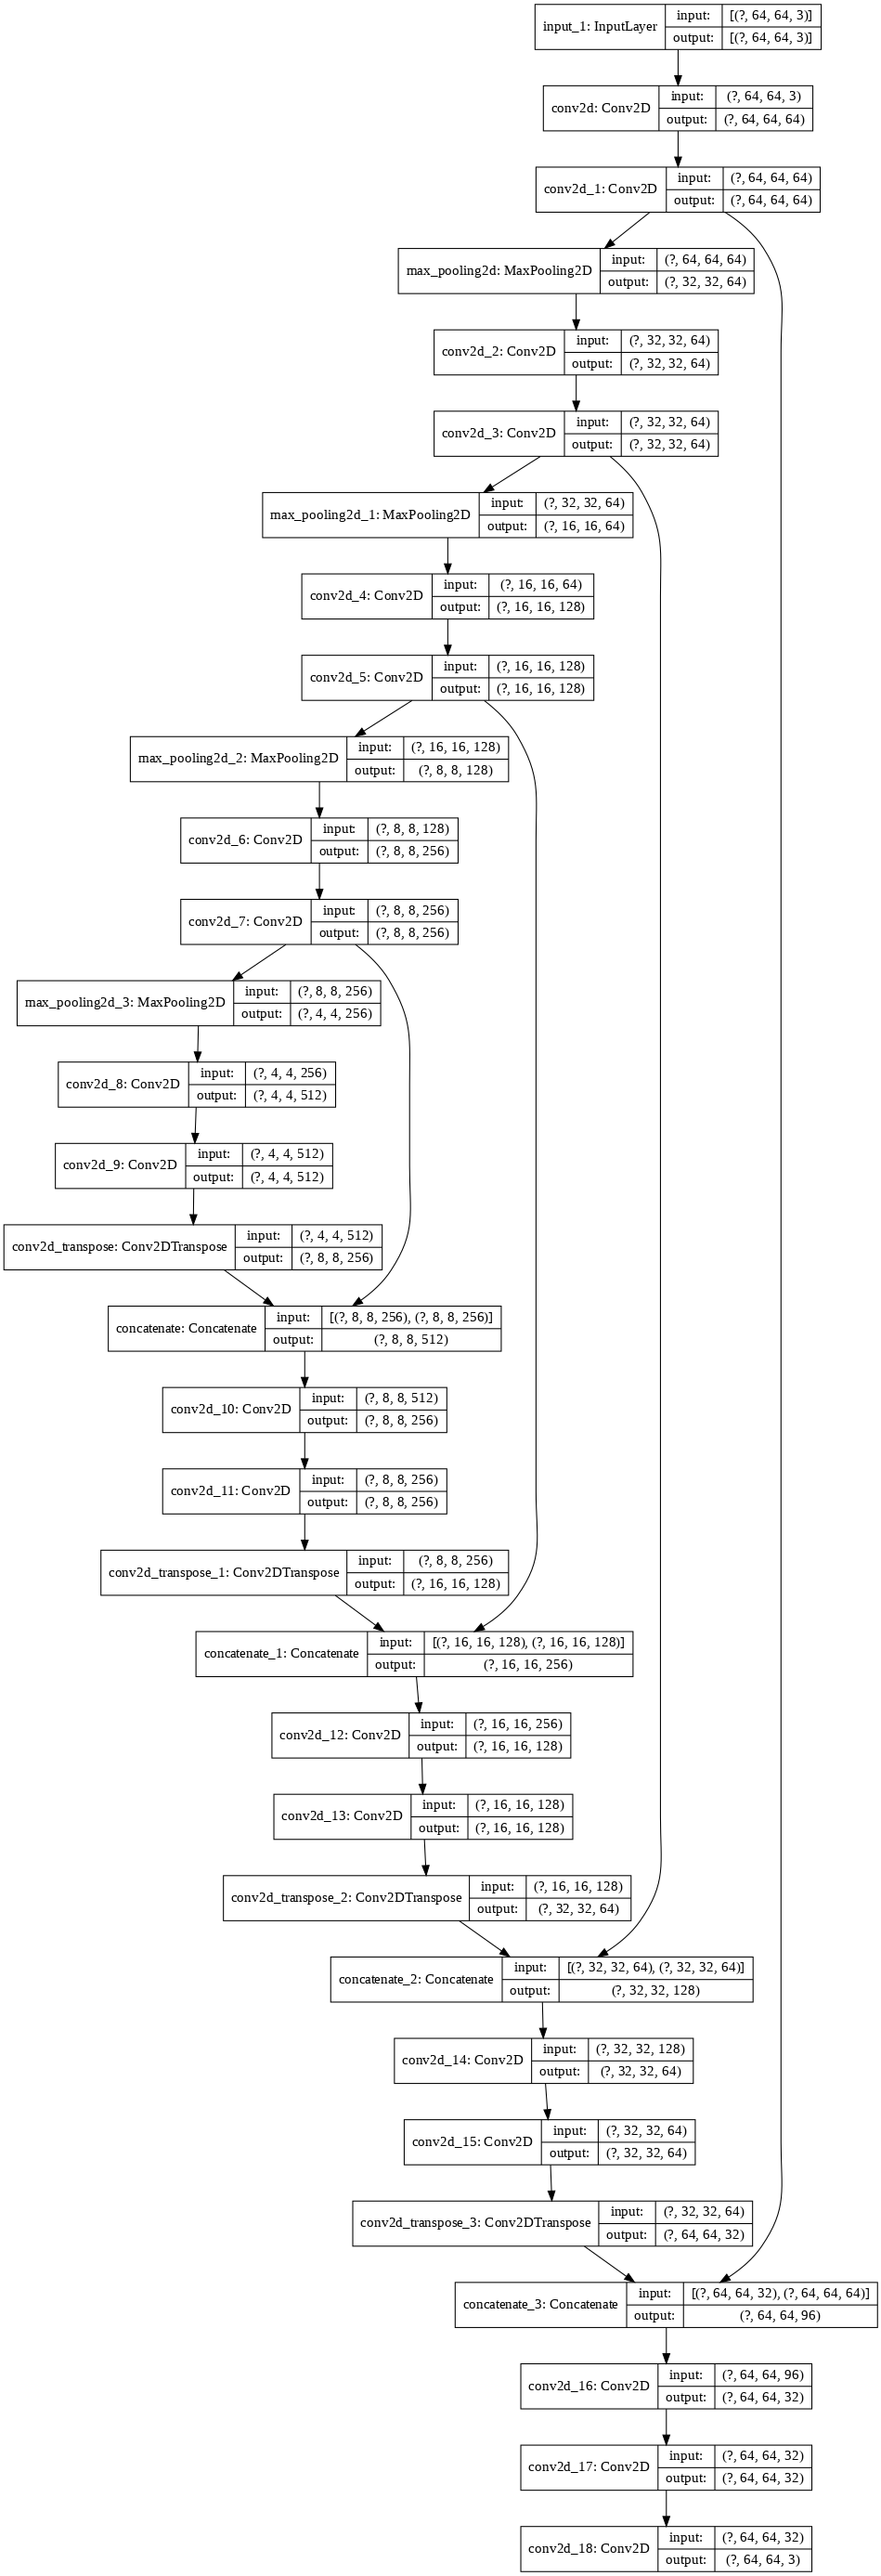

In [15]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

In [16]:
class PredictionLogger(tf.keras.callbacks.Callback):
   def __init__(self):
       super(PredictionLogger, self).__init__()

       # The callback will be executed after an epoch is completed
   def on_epoch_end(self, logs, epoch):
       # Pick a batch, and sample the masked images, masks, and the labels
       sample_idx = 54
       sample_images, sample_labels = testgen[sample_idx] 
       
       # Initialize empty lists store intermediate results
       m_images = []
       predictions = []
       labels = []
       
       # Iterate over the batch
       for i in range(32):
         # Our inpainting model accepts masked imaged and masks as its inputs,
         # then use perform inference
         impainted_image = self.model.predict(np.expand_dims(sample_images[i], axis=0))
       
         # Append the results to the respective lists
         m_images.append(sample_images[i])
         labels.append(sample_labels[i])
         predictions.append(impainted_image.reshape(impainted_image.shape[1:]))

In [ ]:
_ = model.fit(traingen, 
          validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True)
          #callbacks=[PredictionLogger()])

Train for 438 steps, validate for 93 steps
Epoch 1/20
438/438 [==============================] - 70s 160ms/step - loss: 0.0490 - dice_coef: 0.5856 - val_loss: 0.0265 - val_dice_coef: 0.5936
Epoch 2/20
438/438 [==============================] - 63s 145ms/step - loss: 0.0230 - dice_coef: 0.5960 - val_loss: 0.0169 - val_dice_coef: 0.5889
Epoch 3/20
438/438 [==============================] - 63s 143ms/step - loss: 0.0183 - dice_coef: 0.5972 - val_loss: 0.0223 - val_dice_coef: 0.5922
Epoch 4/20
438/438 [==============================] - 63s 143ms/step - loss: 0.0163 - dice_coef: 0.5977 - val_loss: 0.0159 - val_dice_coef: 0.5851
Epoch 5/20
438/438 [==============================] - 63s 143ms/step - loss: 0.0150 - dice_coef: 0.5980 - val_loss: 0.0144 - val_dice_coef: 0.5879
Epoch 6/20
438/438 [==============================] - 63s 143ms/step - loss: 0.0156 - dice_coef: 0.5980 - val_loss: 0.0131 - val_dice_coef: 0.5877
Epoch 7/20
438/438 [==============================] - 63s 143ms/step - loss

In [ ]:
## Examples
rows = 32
sample_idx = 54
sample_images, sample_labels = traingen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

for i in range(32):
  impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
  axs[i][0].imshow(sample_labels[i])
  axs[i][1].imshow(sample_images[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()

In [ ]:
model.save("./drive/MyDrive/ECE_6254/my_new_model")

In [ ]:
## Legend: Original Image | Mask generated | Inpainted Image | Ground Truth
from skimage.metrics import structural_similarity as SSIM
## Examples
rows = 32
sample_idx = 54
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(8, 2*rows))

for i in range(32):
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  impainted_image = model.predict(inputs)
  img_orig_gray = cv2.cvtColor(sample_labels[i].astype('uint8'),cv2.COLOR_BGR2GRAY)
  img_inpainted_gray = cv2.cvtColor(impainted_image.reshape(impainted_image.shape[1:]).astype('uint8'),cv2.COLOR_BGR2GRAY)
  PSNR_val = cv2.PSNR(img_orig_gray, img_inpainted_gray, 255)
  #print(PSNR)
  #SSIM_val = SSIM(sample_labels[i], impainted_image.reshape(impainted_image.shape[1:]),multichannel=True)
  SSIM_val = SSIM(img_orig_gray, img_inpainted_gray,multichannel=True)
  
  print("Image (%i): PSNR = %f, SSIM = %f"%(i+1,PSNR_val,SSIM_val))

  # Plotting:
  axs[i][0].imshow(sample_labels[i])                                              # Ground truth
  axs[i][1].imshow(masked_images[i])                                              # Masked image
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  #axs[i][0].set_xlabel('PSNR : ' + str(PSNR_val) + '\nSSIM: ' + str(SSIM_val))
  
  #axs[i][0].imshow(masked_images[i])
  #axs[i][1].imshow(masks[i])
  #axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  ##print(impainted_image.shape[1:])
  #axs[i][3].imshow(sample_labels[i]